# Export to visualization

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

In [ ]:
from spanda.data.transforms.kssl import (get_spectra_files, to_spectra, 
                                         snv, avg, AnalytesTfm)

from pathlib import Path
from fastai.vision.all import *
#from fastai.callback.hook import *
#from fastai.data.all import *
from fastcore.parallel import parallel
from tqdm import tqdm

from mirzai.data.transform import TakeDerivative, SNV, DropSpectralRegions
from mirzai.vis.core import plot_spectra
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import kennard_stone as ks
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from scipy.stats import skew

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## PLSR

In [ ]:
path = Path('../../_data/kssl-mirs-v2'); path

Path('../../_data/kssl-mirs-v2')

In [ ]:
path.ls()

(#46305) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

In [ ]:
#{'smp_id': [], 'fname': [], '4000': []}
#{'smp_id': [], , ..., 'kex': []}


In [ ]:
#|eval: false
tls = TfmdLists(path.ls(), [get_spectra_files, to_spectra, avg])
tls[:2]

(#2) [Spectra([[0.1842, 0.1845, 0.1847,  ..., 1.5263, 1.5205, 1.5160]]),Spectra([[0.1070, 0.1074, 0.1078,  ..., 1.5550, 1.5532, 1.5531]])]

In [ ]:
spectra = {}
for p in path.ls():
    print(p.ls())

[Path('../../_data/kssl-mirs-v2/180338/260043XS04.csv'), Path('../../_data/kssl-mirs-v2/180338/260043XS01.csv'), Path('../../_data/kssl-mirs-v2/180338/260043XS02.csv'), Path('../../_data/kssl-mirs-v2/180338/260043XS03.csv'), Path('../../_data/kssl-mirs-v2/180338/target.csv')]
[Path('../../_data/kssl-mirs-v2/172221/target.csv'), Path('../../_data/kssl-mirs-v2/172221/240596XS01.csv'), Path('../../_data/kssl-mirs-v2/172221/240596XS03.csv'), Path('../../_data/kssl-mirs-v2/172221/240596XS02.csv'), Path('../../_data/kssl-mirs-v2/172221/240596XS04.csv')]
[Path('../../_data/kssl-mirs-v2/177753/253706XS04.csv'), Path('../../_data/kssl-mirs-v2/177753/253706XS02.csv'), Path('../../_data/kssl-mirs-v2/177753/target.csv'), Path('../../_data/kssl-mirs-v2/177753/253706XS03.csv'), Path('../../_data/kssl-mirs-v2/177753/253706XS01.csv')]
[Path('../../_data/kssl-mirs-v2/184798/target.csv'), Path('../../_data/kssl-mirs-v2/184798/268785XS04.csv'), Path('../../_data/kssl-mirs-v2/184798/268785XS02.csv'), Path

[Path('../../_data/kssl-mirs-v2/177339/252700XS04.csv'), Path('../../_data/kssl-mirs-v2/177339/252700XS03.csv'), Path('../../_data/kssl-mirs-v2/177339/target.csv'), Path('../../_data/kssl-mirs-v2/177339/252700XS02.csv'), Path('../../_data/kssl-mirs-v2/177339/252700XS01.csv')]
[Path('../../_data/kssl-mirs-v2/59609/target.csv'), Path('../../_data/kssl-mirs-v2/59609/147258XS04.csv'), Path('../../_data/kssl-mirs-v2/59609/147258XS01.csv'), Path('../../_data/kssl-mirs-v2/59609/147258XS03.csv'), Path('../../_data/kssl-mirs-v2/59609/147258XS02.csv')]
[Path('../../_data/kssl-mirs-v2/185220/269967XS04.csv'), Path('../../_data/kssl-mirs-v2/185220/269967XS01.csv'), Path('../../_data/kssl-mirs-v2/185220/269967XS03.csv'), Path('../../_data/kssl-mirs-v2/185220/269967XS02.csv'), Path('../../_data/kssl-mirs-v2/185220/target.csv')]
[Path('../../_data/kssl-mirs-v2/53333/132828XS04.csv'), Path('../../_data/kssl-mirs-v2/53333/132828XS02.csv'), Path('../../_data/kssl-mirs-v2/53333/132828XS03.csv'), Path('..

[Path('../../_data/kssl-mirs-v2/43591/target.csv'), Path('../../_data/kssl-mirs-v2/43591/113470XS04.csv'), Path('../../_data/kssl-mirs-v2/43591/113470XS02.csv'), Path('../../_data/kssl-mirs-v2/43591/113470XS03.csv'), Path('../../_data/kssl-mirs-v2/43591/113470XS01.csv')]
[Path('../../_data/kssl-mirs-v2/200022/294499XS04.csv'), Path('../../_data/kssl-mirs-v2/200022/294499XS03.csv'), Path('../../_data/kssl-mirs-v2/200022/294499XS02.csv'), Path('../../_data/kssl-mirs-v2/200022/294499XS01.csv'), Path('../../_data/kssl-mirs-v2/200022/target.csv')]
[Path('../../_data/kssl-mirs-v2/49897/125351XS04.csv'), Path('../../_data/kssl-mirs-v2/49897/125351XS03.csv'), Path('../../_data/kssl-mirs-v2/49897/125351XS02.csv'), Path('../../_data/kssl-mirs-v2/49897/target.csv'), Path('../../_data/kssl-mirs-v2/49897/125351XS01.csv')]
[Path('../../_data/kssl-mirs-v2/51054/128638XS04.csv'), Path('../../_data/kssl-mirs-v2/51054/128638XS03.csv'), Path('../../_data/kssl-mirs-v2/51054/128638XS02.csv'), Path('../../_

[Path('../../_data/kssl-mirs-v2/180561/260460XS04.csv'), Path('../../_data/kssl-mirs-v2/180561/260460XS01.csv'), Path('../../_data/kssl-mirs-v2/180561/260460XS02.csv'), Path('../../_data/kssl-mirs-v2/180561/260460XS03.csv'), Path('../../_data/kssl-mirs-v2/180561/target.csv')]
[Path('../../_data/kssl-mirs-v2/172478/target.csv'), Path('../../_data/kssl-mirs-v2/172478/241047XS01.csv'), Path('../../_data/kssl-mirs-v2/172478/241047XS03.csv'), Path('../../_data/kssl-mirs-v2/172478/241047XS02.csv'), Path('../../_data/kssl-mirs-v2/172478/241047XS04.csv')]
[Path('../../_data/kssl-mirs-v2/119949/217752XS04.csv'), Path('../../_data/kssl-mirs-v2/119949/217752XS02.csv'), Path('../../_data/kssl-mirs-v2/119949/target.csv'), Path('../../_data/kssl-mirs-v2/119949/217752XS03.csv'), Path('../../_data/kssl-mirs-v2/119949/217752XS01.csv')]
[Path('../../_data/kssl-mirs-v2/97923/target.csv'), Path('../../_data/kssl-mirs-v2/97923/195616XS01.csv'), Path('../../_data/kssl-mirs-v2/97923/195616XS02.csv'), Path('.

[Path('../../_data/kssl-mirs-v2/25293/target.csv'), Path('../../_data/kssl-mirs-v2/25293/70082XS02.csv'), Path('../../_data/kssl-mirs-v2/25293/70082XS03.csv'), Path('../../_data/kssl-mirs-v2/25293/70082XS01.csv'), Path('../../_data/kssl-mirs-v2/25293/70082XS04.csv')]
[Path('../../_data/kssl-mirs-v2/178251/254901XS01.csv'), Path('../../_data/kssl-mirs-v2/178251/254901XS03.csv'), Path('../../_data/kssl-mirs-v2/178251/254901XS02.csv'), Path('../../_data/kssl-mirs-v2/178251/target.csv'), Path('../../_data/kssl-mirs-v2/178251/254901XS04.csv')]
[Path('../../_data/kssl-mirs-v2/56761/140572XS01.csv'), Path('../../_data/kssl-mirs-v2/56761/140572XS03.csv'), Path('../../_data/kssl-mirs-v2/56761/140572XS02.csv'), Path('../../_data/kssl-mirs-v2/56761/140572XS04.csv'), Path('../../_data/kssl-mirs-v2/56761/target.csv')]
[Path('../../_data/kssl-mirs-v2/196717/287565XS01.csv'), Path('../../_data/kssl-mirs-v2/196717/287565XS02.csv'), Path('../../_data/kssl-mirs-v2/196717/287565XS03.csv'), Path('../../_d

[Path('../../_data/kssl-mirs-v2/51111/128832XS04.csv'), Path('../../_data/kssl-mirs-v2/51111/128832XS01.csv'), Path('../../_data/kssl-mirs-v2/51111/target.csv'), Path('../../_data/kssl-mirs-v2/51111/128832XS02.csv'), Path('../../_data/kssl-mirs-v2/51111/128832XS03.csv')]
[Path('../../_data/kssl-mirs-v2/171789/target.csv'), Path('../../_data/kssl-mirs-v2/171789/239379XS04.csv'), Path('../../_data/kssl-mirs-v2/171789/239379XS01.csv'), Path('../../_data/kssl-mirs-v2/171789/239379XS03.csv'), Path('../../_data/kssl-mirs-v2/171789/239379XS02.csv')]
[Path('../../_data/kssl-mirs-v2/54651/target.csv'), Path('../../_data/kssl-mirs-v2/54651/136063XS04.csv'), Path('../../_data/kssl-mirs-v2/54651/136063XS02.csv'), Path('../../_data/kssl-mirs-v2/54651/136063XS03.csv'), Path('../../_data/kssl-mirs-v2/54651/136063XS01.csv')]
[Path('../../_data/kssl-mirs-v2/30314/81320XS02.csv'), Path('../../_data/kssl-mirs-v2/30314/81320XS03.csv'), Path('../../_data/kssl-mirs-v2/30314/81320XS01.csv'), Path('../../_dat

[Path('../../_data/kssl-mirs-v2/3820/31982XS01.csv'), Path('../../_data/kssl-mirs-v2/3820/31982XS03.csv'), Path('../../_data/kssl-mirs-v2/3820/31982XS02.csv'), Path('../../_data/kssl-mirs-v2/3820/31982XS04.csv'), Path('../../_data/kssl-mirs-v2/3820/target.csv')]
[Path('../../_data/kssl-mirs-v2/29636/80161XS03.csv'), Path('../../_data/kssl-mirs-v2/29636/80161XS02.csv'), Path('../../_data/kssl-mirs-v2/29636/80161XS01.csv'), Path('../../_data/kssl-mirs-v2/29636/80161XS04.csv'), Path('../../_data/kssl-mirs-v2/29636/target.csv')]
[Path('../../_data/kssl-mirs-v2/47649/target.csv'), Path('../../_data/kssl-mirs-v2/47649/120949XS02.csv'), Path('../../_data/kssl-mirs-v2/47649/120949XS03.csv'), Path('../../_data/kssl-mirs-v2/47649/120949XS01.csv'), Path('../../_data/kssl-mirs-v2/47649/120949XS04.csv')]
[Path('../../_data/kssl-mirs-v2/170254/236272XS01.csv'), Path('../../_data/kssl-mirs-v2/170254/236272XS02.csv'), Path('../../_data/kssl-mirs-v2/170254/236272XS03.csv'), Path('../../_data/kssl-mirs-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Path('../../_data/kssl-mirs-v2/120289/222154XS04.csv'), Path('../../_data/kssl-mirs-v2/120289/222154XS03.csv'), Path('../../_data/kssl-mirs-v2/120289/222154XS02.csv'), Path('../../_data/kssl-mirs-v2/120289/222154XS01.csv'), Path('../../_data/kssl-mirs-v2/120289/target.csv')]
[Path('../../_data/kssl-mirs-v2/42496/target.csv'), Path('../../_data/kssl-mirs-v2/42496/111029XS03.csv'), Path('../../_data/kssl-mirs-v2/42496/111029XS02.csv'), Path('../../_data/kssl-mirs-v2/42496/111029XS01.csv'), Path('../../_data/kssl-mirs-v2/42496/111029XS04.csv')]
[Path('../../_data/kssl-mirs-v2/189008/276358XS04.csv'), Path('../../_data/kssl-mirs-v2/189008/276358XS03.csv'), Path('../../_data/kssl-mirs-v2/189008/target.csv'), Path('../../_data/kssl-mirs-v2/189008/276358XS02.csv'), Path('../../_data/kssl-mirs-v2/189008/276358XS01.csv')]
[Path('../../_data/kssl-mirs-v2/212532/321568XS01.csv'), Path('../../_data/kssl-mirs-v2/212532/321568XS02.csv'), Path('../../_data/kssl-mirs-v2/212532/321568XS03.csv'), Path(

In [ ]:
L(fname for fname in path.ls() if re.match('\d', fname.name))

(#46305) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

In [ ]:
wns = pd.read_csv((path / 'train').ls()[0] / 'spectrum.csv')['wavenumber'].values; wns

array([4000, 3998, 3996, ...,  606,  604,  602])

In [ ]:
Xs = []
for ds in ['train', 'test']:
    Xs.append(np.c_[[pd.read_csv(p / 'spectrum.csv')['absorbance'].values 
                     for p in (path / ds).ls()]])
X_train, X_test = Xs

In [ ]:
ys = []
for ds in ['train', 'test']:
    ys.append(np.c_[[pd.read_csv(p / 'target.csv')['value'].values 
                     for p in (path / ds).ls()]])
y_train, y_test = ys

In [ ]:
print(f'# of training sample: {y_train.shape[0]}, # of test samples: {y_test.shape[0]}')

# of training sample: 59, # of test samples: 35


In [ ]:
# y transforms if required
y_train, y_test = [np.log10(y) for y in [y_train, y_test]]

In [ ]:
wns

array([4000, 3998, 3996, ...,  606,  604,  602])

### Train locally

In [ ]:
param_grid = {'model__n_components': range(2,10)}

In [ ]:
pipe = Pipeline([
    ('snv', SNV()),
    ('derivative', TakeDerivative()),
    #('dropper', DropSpectralRegions(self.X_names, **self.pipeline_kwargs['dropper'])),
    ('model', PLSRegression())])

In [ ]:
search = GridSearchCV(pipe, param_grid, scoring='r2',
                      n_jobs=-1, refit=True, cv=5)

In [ ]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('snv', SNV()),
                                       ('derivative', TakeDerivative()),
                                       ('model', PLSRegression())]),
             n_jobs=-1, param_grid={'model__n_components': range(2, 10)},
             scoring='r2')

In [ ]:
search.best_score_

0.5611929938100564

In [ ]:
search.best_params_

{'model__n_components': 4}

In [ ]:
r2_score(y_test, search.best_estimator_.predict(X_test))

0.8737580035054922

In [ ]:
np.c_[search.best_estimator_.predict(X_test), y_test]

array([[-0.53303796, -0.43513281],
       [-0.31246281, -0.36326143],
       [-0.65729713, -0.72706822],
       [-0.3258024 , -0.46885332],
       [-0.06219543, -0.01689717],
       [-0.31081636, -0.40990529],
       [-0.23628007, -0.31652068],
       [-0.35223754, -0.36550258],
       [-0.65687122, -0.78220032],
       [-0.32756555, -0.36478777],
       [-0.18154254, -0.31256915],
       [-0.21304433, -0.19295908],
       [-0.34520746, -0.36209019],
       [-0.35281802, -0.44526862],
       [-0.34421669, -0.43066121],
       [-0.34379054, -0.39225554],
       [-0.24423739, -0.30168193],
       [-0.06526925,  0.0234212 ],
       [-0.96290019, -0.95159704],
       [-0.46505578, -0.63173171],
       [-0.21539115, -0.22201526],
       [-0.05834217,  0.02993543]])

### Trained with KSSL

In [ ]:
# TBD

# Pre-trained Resnet

In [ ]:
#org = 'Woodwell_vertex'
org = 'IAEA_jun2022'
#org = 'ETH_alpha_1'
analyte = 'potassium_cmolkg'

path = Path('../../_data/wcrc-ct-bundled') / org / analyte; path

Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg')

In [ ]:
(path / 'train').ls()

(#59) [Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_23'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_24'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_12'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_15'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_41'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_46'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_48'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_14'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_13'),Path('../../_data/wcrc-ct-bundled/IAEA_jun2022/potassium_cmolkg/train/RT_25')...]

## No fine tuning

In [ ]:
x_tfms = [get_spectra_files, to_spectra, snv]
y_tfms = [AnalytesTfm(analytes=[analyte]), torch.log10]

# Pre-trained model
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
weights_paths = '../../_data/models/xresnet18-k-ex-snv-lr-5e-4-r2-0-828.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
# Eval on train
dsets = Datasets((path / 'train').ls(), [x_tfms, y_tfms])
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)
print(dls.train.one_batch()[0].shape)

y_train_hat = model(dls.train.one_batch()[0]).detach().numpy()
y_train_true = dls.train.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

torch.Size([59, 1, 1700])


0.0617554475217279

In [ ]:
# Eval on test
dsets = Datasets((path / 'test').ls(), [x_tfms, y_tfms])
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)

print(dls.train.one_batch()[0].shape)
y_train_hat = model(dls.train.one_batch()[0]).detach().numpy()
y_train_true = dls.train.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

torch.Size([35, 1, 1700])


0.16538594424873831

## Fine tuning

In [ ]:
x_tfms = [get_spectra_files, to_spectra, snv]
y_tfms = [AnalytesTfm(analytes=[analyte]), torch.log10]

# Data loader
splits = RandomSplitter(seed=42, valid_pct=0.2)((path / 'train').ls())
dsets = Datasets((path / 'train').ls(), [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=16, num_workers=8, drop_last=False, shuffle=True)
print('ds size: ', dls.train.one_batch()[0].shape)

# Pre-trained model
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
weights_paths = '../../_data/models/xresnet18-k-ex-snv-lr-5e-4-r2-0-828.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

ds size:  torch.Size([16, 1, 1700])


<All keys matched successfully>

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

In [ ]:
learn.freeze_to(-1)

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastprogress/fastprogress.py:73: UserW

SuggestedLRs(valley=0.00013182566908653826)

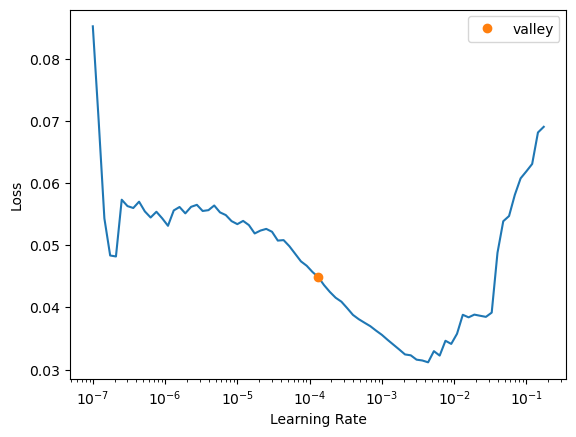

In [ ]:
#learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,r2_score,time
0,0.141209,0.140845,-0.425856,00:03
1,0.131625,0.089103,0.097955,00:03
2,0.115335,0.113007,-0.144036,00:03
3,0.097671,0.089859,0.090302,00:03
4,0.084289,0.061286,0.379563,00:04
5,0.072791,0.048429,0.509723,00:03
6,0.063672,0.044960,0.544840,00:03
7,0.056216,0.043164,0.563021,00:03
8,0.050133,0.042254,0.572240,00:03
9,0.045324,0.041596,0.578900,00:03


In [ ]:
# Eval on train
dsets = Datasets((path / 'train').ls(), [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)

y_train_hat = learn.model(dls.train.one_batch()[0]).detach().numpy()
y_train_true = dls.train.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

0.9401470543176677

In [ ]:
# Eval on test
dsets = Datasets((path / 'test').ls(), [x_tfms, y_tfms])
dls = dsets.dataloaders(bs=64, num_workers=8, drop_last=False, shuffle=False)

print(dls.train.one_batch()[0].shape)
y_train_hat = learn.model(dls.train.one_batch()[0]).detach().numpy()
y_train_true = dls.train.one_batch()[1].numpy()

r2_score(y_train_true, y_train_hat)

torch.Size([35, 1, 1700])


0.7876747440636364

<matplotlib.collections.PathCollection>

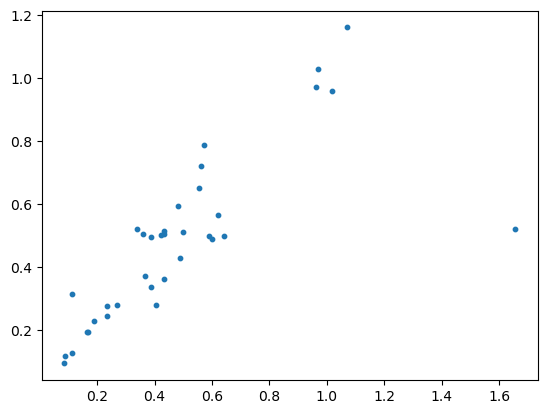

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(np.power(10, y_train_true), np.power(10, y_train_hat), s=10)

In [ ]:
np.c_[np.power(10, y_train_true), np.power(10, y_train_hat)]

array([[0.36717   , 0.49965754],
       [0.6195    , 0.6120763 ],
       [0.43325   , 0.45367438],
       [0.23467001, 0.2585495 ],
       [0.56302   , 0.5218458 ],
       [0.18747002, 0.19640796],
       [0.55602   , 0.6289487 ],
       [0.33974   , 0.304987  ],
       [0.96184   , 1.0822989 ],
       [0.493     , 0.39163893],
       [0.38913   , 0.33028385],
       [0.48248   , 0.4977107 ],
       [0.43102   , 0.37487492],
       [1.65621   , 1.3838615 ],
       [0.16512002, 0.17862107],
       [0.43173   , 0.48522988],
       [0.38858   , 0.3166398 ],
       [0.48689002, 0.4473663 ],
       [0.64127   , 0.44046792],
       [0.26905996, 0.31475148],
       [0.43442   , 0.49923816],
       [0.3587    , 0.35069907],
       [0.37097   , 0.3338453 ],
       [0.16787   , 0.07103667],
       [0.40527   , 0.51370305],
       [0.49925   , 0.5716585 ],
       [0.29109   , 0.32789767],
       [0.08947   , 0.07293624],
       [0.40292   , 0.38504747],
       [0.58915   , 0.58926207],
       [1.